# Assignment 11 : RL Prediction (part 1)

## 1) Tabular MC from scratch

## Here are the contents of rl/monte\_carlo.py :

In [12]:
'''Monte Carlo methods for working with Markov Reward Process and
Markov Decision Processes.

'''

from typing import Iterable, Iterator, Tuple, TypeVar, Callable, Mapping

from rl.distribution import Distribution
from rl.function_approx import FunctionApprox
import rl.markov_process as mp
import rl.markov_decision_process as markov_decision_process
from rl.markov_decision_process import (MarkovDecisionProcess)
from rl.returns import returns

S = TypeVar('S')
A = TypeVar('A')


def mc_prediction(
        traces: Iterable[Iterable[mp.TransitionStep[S]]],
        approx_0: FunctionApprox[S],
        γ: float,
        tolerance: float = 1e-6
) -> Iterator[FunctionApprox[S]]:
    '''Evaluate an MRP using the monte carlo method, simulating episodes
    of the given number of steps.

    Each value this function yields represents the approximated value
    function for the MRP after one additional epsiode.

    Arguments:
      traces -- an iterator of simulation traces from an MRP
      approx_0 -- initial approximation of value function
      γ -- discount rate (0 < γ ≤ 1), default: 1
      tolerance -- a small value—we stop iterating once γᵏ ≤ tolerance

    Returns an iterator with updates to the approximated value
    function after each episode.

    '''
    episodes = (returns(trace, γ, tolerance) for trace in traces)

    return approx_0.iterate_updates(
        ((step.state, step.return_) for step in episode)
        for episode in episodes
    )




We are going to make it pretty general, allowing the user to specify a function counts\_to\_weights that we will call $f$ to stick with the lecture's notation.

The inputs are traces, $\gamma$ and tolerance (unchanged). We replace approx_0 by the function $f$ used for tabular updates. The function outputs a Mapping from states (assumed finite) to floats representing the final value function $V$.

In [44]:
def mc_tabular_prediction(
        traces: Iterable[Iterable[mp.TransitionStep[S]]],
        γ: float,
        f : Callable[[int], float] = lambda n : 1/n,
        tolerance: float = 1e-6
) -> Mapping[S, float]:
    
    table  :  Mapping[S, float] = dict()
    counts :  Mapping[S, int]   = dict()
    
    episodes = (returns(trace, γ, tolerance) for trace in traces)
    
    for episode in episodes:
        for step in episode:
            counts[step.state] = counts.get(step.state, 0) + 1
            if counts[step.state] == 1:
                table[step.state] = step.return_
            else:
                table[step.state] = step.return_ * f(counts[step.state])+(1-f(counts[step.state]))*table.get(step.state, 0.)
    return table


## 2) Tabular Temporal-Difference from scratch

#### Here are the contents of rl/td.py : 


In [16]:
from typing import Callable, Iterable, Iterator, TypeVar, Tuple

from rl.function_approx import FunctionApprox
import rl.markov_process as mp
import rl.markov_decision_process as mdp
import rl.iterate as iterate

S = TypeVar('S')


def td_prediction(
        transitions: Iterable[mp.TransitionStep[S]],
        approx_0: FunctionApprox[S],
        γ: float,
) -> Iterator[FunctionApprox[S]]:
    '''Evaluate an MRP using TD(0) using the given sequence of
    transitions.

    Each value this function yields represents the approximated value
    function for the MRP after an additional transition.

    Arguments:
      transitions -- a sequence of transitions from an MRP which don't
                     have to be in order or from the same simulation
      approx_0 -- initial approximation of value function
      γ -- discount rate (0 < γ ≤ 1)

    '''
    def step(v, transition):
        return v.update([(transition.state,
                          transition.reward + γ * v(transition.next_state))])

    return iterate.accumulate(transitions, step, initial=approx_0)


## In a similar fashion, we replace approx\_0 by the specification of f : 

In [58]:
def td_tabular_prediction(
        transitions: Iterable[mp.TransitionStep[S]],
        γ: float,
        f : Callable[[int], float] = lambda n : 1/n
) -> Mapping[S, float]:

    
    table  :  Mapping[S, float] = dict()
    counts :  Mapping[S, int]   = dict()

    for step in transitions:
        counts[step.state] = counts.get(step.state, 0) + 1
        if counts[step.state] == 1:
            table[step.state] = step.reward
        else:
            table[step.state] = (step.reward + γ * table.get(step.next_state, 0.) - table.get(step.state, 0.)) * f(counts[step.state])+ table.get(step.state, 0.)
    return table


## 3) Let's test and compare our functions on the Simple Inventory example

In [52]:
from rl.chapter2.simple_inventory_mrp import SimpleInventoryMRPFinite, InventoryState

user_capacity = 2
user_poisson_lambda = 1.0
user_holding_cost = 1.0
user_stockout_cost = 10.0

user_gamma = 0.9

si_mrp = SimpleInventoryMRPFinite(
    capacity=user_capacity,
    poisson_lambda=user_poisson_lambda,
    holding_cost=user_holding_cost,
    stockout_cost=user_stockout_cost
)

print("Value Function")
print("--------------")
si_mrp.display_value_function(gamma=user_gamma)
print()

Value Function
--------------
{InventoryState(on_hand=1, on_order=0): -28.932,
 InventoryState(on_hand=1, on_order=1): -29.345,
 InventoryState(on_hand=2, on_order=0): -30.345,
 InventoryState(on_hand=0, on_order=0): -35.511,
 InventoryState(on_hand=0, on_order=1): -27.932,
 InventoryState(on_hand=0, on_order=2): -28.345}



# MC converges fast with simple averaging as $f$

In [51]:
from itertools import islice
episodes = islice(si_mrp.reward_traces(Constant(InventoryState(0,0))), 100)
table_mc = mc_tabular_prediction(episodes, user_gamma)
table_mc

{InventoryState(on_hand=0, on_order=0): -35.37499259296973,
 InventoryState(on_hand=0, on_order=2): -28.188519503557927,
 InventoryState(on_hand=1, on_order=0): -28.885416754229663,
 InventoryState(on_hand=0, on_order=1): -27.832750921069934,
 InventoryState(on_hand=1, on_order=1): -29.261087321824473,
 InventoryState(on_hand=2, on_order=0): -30.22427418120901}

It is not the same order of keys, but the MC value function is the same as that obtained analytically.
Let's compute it with TD :

## TD with naive average as f is not converging ...

### This is to be expected since the initial boostrapped estimates are very bad and we must forget what was learned at the beginnning of training to get rid of the bias....

In [66]:
transitions = islice(si_mrp.simulate_reward(Constant(InventoryState(0,0))), 1000)
table_td = td_tabular_prediction(transitions, user_gamma)
table_td

{InventoryState(on_hand=0, on_order=0): -17.589905522960837,
 InventoryState(on_hand=0, on_order=2): -10.602750178641903,
 InventoryState(on_hand=2, on_order=0): -12.916651578910775,
 InventoryState(on_hand=1, on_order=0): -12.338258635044827,
 InventoryState(on_hand=1, on_order=1): -12.117442034710983,
 InventoryState(on_hand=0, on_order=1): -11.4163098742954}

In [67]:
transitions = islice(si_mrp.simulate_reward(Constant(InventoryState(0,0))), 100000)
table_td = td_tabular_prediction(transitions, user_gamma)
table_td

{InventoryState(on_hand=0, on_order=0): -24.72484422537357,
 InventoryState(on_hand=0, on_order=2): -17.57673908729679,
 InventoryState(on_hand=2, on_order=0): -19.54157923812064,
 InventoryState(on_hand=1, on_order=0): -18.179451123618797,
 InventoryState(on_hand=0, on_order=1): -17.185760282974428,
 InventoryState(on_hand=1, on_order=1): -18.528461587007595}

## Switching to an exponential decay as learning rate grants us convergence

In [70]:
transitions = islice(si_mrp.simulate_reward(Constant(InventoryState(0,0))), 10000)
table_td = td_tabular_prediction(transitions, user_gamma, f = lambda n : 0.05)
table_td

{InventoryState(on_hand=0, on_order=0): -35.839584609262296,
 InventoryState(on_hand=0, on_order=2): -28.551217393378355,
 InventoryState(on_hand=1, on_order=0): -29.144318746166075,
 InventoryState(on_hand=0, on_order=1): -28.296515448516118,
 InventoryState(on_hand=1, on_order=1): -29.46196739301054,
 InventoryState(on_hand=2, on_order=0): -30.1767184009853}

## RandomWalk2D : strolling on a grid

Below is the original code for RandomWalkMRP:

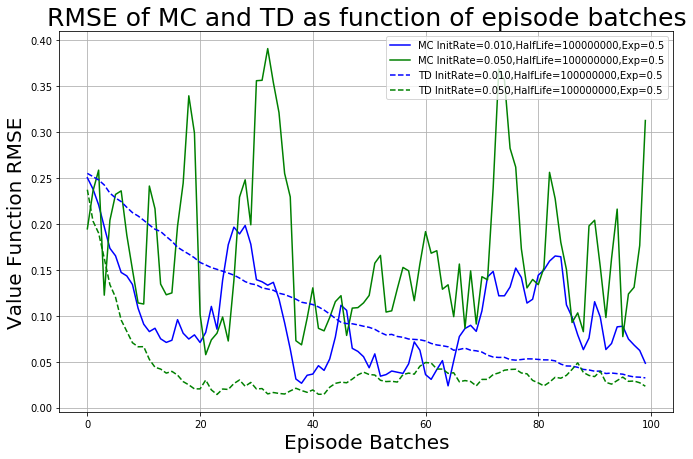

In [73]:
from typing import Mapping, Dict, Optional, Tuple
from rl.distribution import Categorical
from rl.markov_process import FiniteMarkovRewardProcess
import matplotlib.pyplot as plt

class RandomWalkMRP(FiniteMarkovRewardProcess[int]):
    '''
    This MRP's states are {0, 1, 2,...,self.barrier}
    with 0 and self.barrier as the terminal states.
    At each time step, we go from state i to state
    i+1 with probability self.p or to state i-1 with
    probability 1-self.p, for all 0 < i < self.barrier.
    The reward is 0 if we transition to a non-terminal
    state or to terminal state 0, and the reward is 1
    if we transition to terminal state self.barrier
    '''
    barrier: int
    p: float

    def __init__(
        self,
        barrier: int,
        p: float
    ):
        self.barrier = barrier
        self.p = p
        super().__init__(self.get_transition_map())

    def get_transition_map(self) -> \
            Mapping[int, Optional[Categorical[Tuple[int, float]]]]:
        d: Dict[int, Optional[Categorical[Tuple[int, float]]]] = {
            i: Categorical({
                (i + 1, 0. if i < self.barrier - 1 else 1.): self.p,
                (i - 1, 0.): 1 - self.p
            }) for i in range(1, self.barrier)
        }
        d[0] = None
        d[self.barrier] = None
        return d


from rl.chapter10.prediction_utils import compare_td_and_mc

this_barrier: int = 10
this_p: float = 0.5
random_walk: RandomWalkMRP = RandomWalkMRP(
    barrier=this_barrier,
    p=this_p
)
compare_td_and_mc(
    fmrp=random_walk,
    gamma=1.0,
    mc_episode_length_tol=1e-6,
    num_episodes=700,
    learning_rates=[(0.01, 1e8, 0.5), (0.05, 1e8, 0.5)],
    initial_vf_dict={s: 0.5 for s in random_walk.non_terminal_states},
    plot_batch=7,
    plot_start=0
)
plt.show()

In [85]:
UP,DOWN,LEFT,RIGHT = "UP", "DOWN", "LEFT", 'RIGHT'
DIRECTIONS = [UP,DOWN,LEFT,RIGHT]


class RandomWalkMRP2D(FiniteMarkovRewardProcess[Tuple[int]]):
    '''
    This MRP's states are (i,j) for 0 <= i , j <= self.B1, self.B2
    with 0 and self.Bi as the terminal states.
    At each time step, we go from state i to an adjacent state
    with fixed probability 
    The reward is 0 if we transition to a non-terminal
    state or to terminal state 0, and the reward is 1
    if we transition to terminal state
    '''
    B1: int
    B2: int
    p: Mapping[str,float]

    def __init__(
        self,
        B1: int,
        B2 : int,
        p: Mapping[str, float] = {direction : 1/4 for direction in DIRECTIONS}
    ):
        self.B1 = B1
        self.B2 = B2
        self.p = p
        super().__init__(self.get_transition_map())

    def get_transition_map(self) -> \
            Mapping[Tuple[int], Optional[Categorical[Tuple[int, float]]]]:
        d: Dict[int, Optional[Categorical[Tuple[int, float]]]] = {
            (i,j): Categorical({
                (self.direction_map(direction, (i,j)), 0. if not self.is_terminal(self.direction_map(direction, (i,j))) else 1.): self.p[direction]
                for direction in DIRECTIONS
                
            }) for i in range(1, self.B1) for j in range(1, self.B2)
        }
        for i in range(self.B1+1):
            d[(i,0)] = None
            d[(i,self.B2)] = None
        for j in range(self.B2+1):
            d[(0,j)] = None
            d[(self.B1,j)] = None
        return d
    
    
    def direction_map(self, direction:str, position: Tuple[int] ) -> Tuple[int]:
        """outputs the position after a move in direction direction from position position"""
        i,j = position
        if direction == UP:
            return (i-1, j)
        elif direction == DOWN:
            return (i+1,j)
        elif direction == LEFT:
            return (i,j-1)
        elif direction == RIGHT:
            return (i,j+1)
        else:
            print("WRONG DIRECTION")
            assert False
    def is_terminal(self, position: Tuple[int])-> bool:
        """returns wether a position is terminal"""
        i,j = position
        return i in [0, self.B1] or j in [0, self.B2]

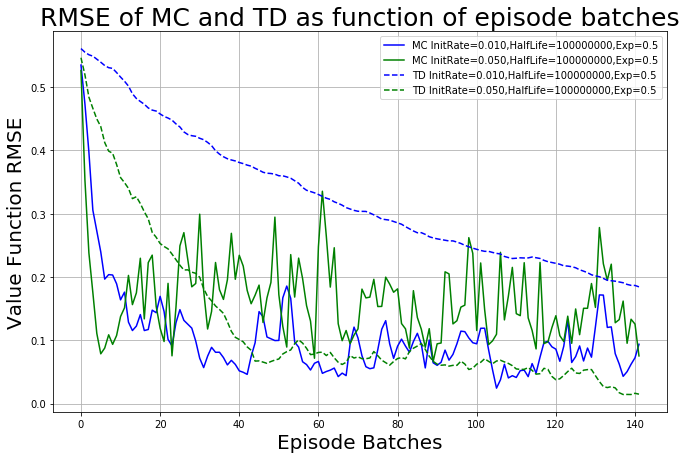

In [89]:
this_B1: int = 20
this_B2: int = 20
this_p: Mapping[str, float] = {direction : 1/4 for direction in DIRECTIONS}
random_walk2D: RandomWalkMRP2D = RandomWalkMRP2D(
    B1=this_B1,
    B2=this_B2,
    p=this_p
)
    
compare_td_and_mc(
    fmrp=random_walk,
    gamma=1.0,
    mc_episode_length_tol=1e-6,
    num_episodes=1000,
    learning_rates=[(0.01, 1e8, 0.5), (0.05, 1e8, 0.5)],
    initial_vf_dict={s: 0.5 for s in random_walk2D.non_terminal_states},
    plot_batch=7,
    plot_start=0
)
plt.show()

## The behavior showcases the pattern mentionned in the class:

TD has smoother convergence and can attain better minima. However the schedule has a large importance, and a low learning rate cas cause slow convergence (blue dotted lines). MC is faster in this experiment, but at the cost of high variance and it fails to stabilize.